In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot as plt
from collections import Counter

# Load dataset
train_data = pd.read_csv('sample_data/train.csv')
test_data = pd.read_csv('sample_data/test.csv')

train_data['Train_Flag'] = 1
test_data['Train_Flag'] = 0
test_data['Crop_Damage'] = 0

merged_dataset = pd.concat((train_data, test_data))

# Convert ID column to integer
merged_dataset['ID_Value'] = merged_dataset['ID'].apply(lambda x: x.strip('F')).astype('int')
merged_dataset = merged_dataset.sort_values(['ID_Value'])
merged_dataset = merged_dataset.reset_index(drop=True)

In [2]:
# Add more columns
merged_dataset['Soil_Type_Damage'] = merged_dataset.sort_values(['ID_Value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values
merged_dataset['Estimated_Insects_Count_Damage'] = merged_dataset.sort_values(['ID_Value']).groupby(['Estimated_Insects_Count'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values
merged_dataset['Crop_Type_Damage'] = merged_dataset.sort_values(['ID_Value']).groupby(['Crop_Type'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values
merged_dataset['Pesticide_Use_Category_Damage'] = merged_dataset.sort_values(['ID_Value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values
merged_dataset['Season_Damage'] = merged_dataset.sort_values(['ID_Value']).groupby(['Season'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values

merged_dataset['Soil_Type_Damage_c2'] = merged_dataset.sort_values(['ID_Value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values
merged_dataset['Estimated_Insects_Count_Damage_c2'] = merged_dataset.sort_values(['ID_Value']).groupby(['Estimated_Insects_Count'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values
merged_dataset['Crop_Type_Damage_c2'] = merged_dataset.sort_values(['ID_Value']).groupby(['Crop_Type'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values
merged_dataset['Pesticide_Use_Category_Damage_c2'] = merged_dataset.sort_values(['ID_Value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values
merged_dataset['Season_Damage_c2'] = merged_dataset.sort_values(['ID_Value']).groupby(['Season'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

merged_dataset.loc[merged_dataset['Train_Flag'] == 0, 'Crop_Damage'] = -999

In [3]:
# Add more feature columns
merged_dataset['Crop_Damage_c1'] = merged_dataset['Crop_Damage'].shift(fill_value=-999)
merged_dataset['Estimated_Insects_Count_c1'] = merged_dataset['Estimated_Insects_Count'].shift(fill_value=-999)
merged_dataset['Crop_Type_c1'] = merged_dataset['Crop_Type'].shift(fill_value=-999)
merged_dataset['Soil_Type_c1'] = merged_dataset['Soil_Type'].shift(fill_value=-999)
merged_dataset['Pesticide_Use_Category_c1'] = merged_dataset['Pesticide_Use_Category'].shift(fill_value=-999)
merged_dataset['Number_Doses_Week_c1'] = merged_dataset['Number_Doses_Week'].shift(fill_value=-999)
merged_dataset['Number_Weeks_Used_c1'] = merged_dataset['Number_Weeks_Used'].shift(fill_value=-999)
merged_dataset['Number_Weeks_Quit_c1'] = merged_dataset['Number_Weeks_Quit'].shift(fill_value=-999)
merged_dataset['Season_c1'] = merged_dataset['Season'].shift(fill_value=-999)

merged_dataset['Crop_Damage_c2'] = merged_dataset['Crop_Damage'].shift(periods=2, fill_value=-999)
merged_dataset['Estimated_Insects_Count_c2'] = merged_dataset['Estimated_Insects_Count'].shift(periods=2, fill_value=-999)
merged_dataset['Crop_Type_c2'] = merged_dataset['Crop_Type'].shift(periods=2, fill_value=-999)
merged_dataset['Soil_Type_c2'] = merged_dataset['Soil_Type'].shift(periods=2, fill_value=-999)
merged_dataset['Pesticide_Use_Category_c2'] = merged_dataset['Pesticide_Use_Category'].shift(periods=2, fill_value=-999)
merged_dataset['Number_Doses_Week_c2'] = merged_dataset['Number_Doses_Week'].shift(periods=2, fill_value=-999)
merged_dataset['Number_Weeks_Used_c2'] = merged_dataset['Number_Weeks_Used'].shift(periods=2, fill_value=-999)
merged_dataset['Number_Weeks_Quit_c2'] = merged_dataset['Number_Weeks_Quit'].shift(periods=2, fill_value=-999)
merged_dataset['Season_c2'] = merged_dataset['Season'].shift(periods=2, fill_value=-999)

In [4]:
# Split data into train and test datasets
train_dataset, test_dataset = merged_dataset[merged_dataset.Train_Flag == 1], merged_dataset[merged_dataset.Train_Flag == 0]

train_dt = train_dataset.drop(columns=['Train_Flag'], axis=11)
test_dt_1 = test_dataset.drop(columns=['Train_Flag'], axis=11)
test_dt = test_dt_1.drop(columns=['Crop_Damage'], axis=10)

# Delete the merged dataset to save memory
del merged_dataset

missing_value = -999

# Assign values to empty cells
train_dt['Number_Weeks_Used'] = train_dt['Number_Weeks_Used'].apply(lambda x: missing_value if pd.isna(x) else x)
test_dt['Number_Weeks_Used'] = test_dt['Number_Weeks_Used'].apply(lambda x: missing_value if pd.isna(x) else x)

train_dt['Number_Weeks_Used_c1'] = train_dt['Number_Weeks_Used_c1'].apply(lambda x: missing_value if pd.isna(x) else x)
test_dt['Number_Weeks_Used_c1'] = test_dt['Number_Weeks_Used_c1'].apply(lambda x: missing_value if pd.isna(x) else x)

train_dt['Number_Weeks_Used_c2'] = train_dt['Number_Weeks_Used_c2'].apply(lambda x: missing_value if pd.isna(x) else x)
test_dt['Number_Weeks_Used_c2'] = test_dt['Number_Weeks_Used_c2'].apply(lambda x: missing_value if pd.isna(x) else x)

dataset_X = train_dt.drop(columns=['Crop_Damage', 'ID', 'ID_Value'])
dataset_y = train_dt['Crop_Damage'].values

# Remove the ID and ID_Value columns from test dataset
test_dt.drop(columns=['ID', 'ID_Value'], inplace=True)

In [5]:
# Split data into train and test
train_X, test_X, train_y, test_y = train_test_split(dataset_X, dataset_y, random_state=42, test_size=0.3, shuffle=True)

"""Using boosted decision tree algorithm on structured data produces better performance
An example of a structured data is the dataset used in this exercise while an images are categorized as unstructured. 

In this case, we are using LightGBM.
"""

cat_cols = ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Season', 'Crop_Type_c1', 'Soil_Type_c1', 'Pesticide_Use_Category_c1', 'Season_c1']

params = {'learning_rate': 0.04, 'max_depth': 18, 'n_estimators': 3000, 'objective': 'multiclass',
          'boosting_type': 'gbdt', 'subsample': 0.7, 'random_state': 42, 'colsample_bytree': 0.7,
          'min_data_in_leaf': 55, 'reg_alpha': 1.7, 'reg_lambda': 1.11}
params['class_weight']: {0: 0.44, 1: 0.4, 2: 0.37}

clf = lgb.LGBMClassifier(**params)


In [6]:
# Train model
clf.fit(train_X, train_y, eval_set=[(train_X, train_y), (test_X, test_y)], eval_metric='multi_error',
early_stopping_rounds=100, categorical_feature=cat_cols)

score = accuracy_score(test_y, clf.predict(test_X))

print(f'\nAccuracy: {score * 100}%')

# Check for overfitting
print(f'Training Score: {clf.score(train_X, train_y) * 100}%')
print(f'Testing Score: {clf.score(test_X, test_y) * 100}%')

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Crop_Type', 'Crop_Type_c1', 'Pesticide_Use_Category', 'Pesticide_Use_Category_c1', 'Season', 'Season_c1', 'Soil_Type', 'Soil_Type_c1']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's multi_error: 0.164277	training's multi_logloss: 0.49531	valid_1's multi_error: 0.165129	valid_1's multi_logloss: 0.498568
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_error: 0.164277	training's multi_logloss: 0.476809	valid_1's multi_error: 0.165129	valid_1's multi_logloss: 0.480669
[3]	training's multi_error: 0.164277	training's multi_logloss: 0.460662	valid_1's multi_error: 0.165129	valid_1's multi_logloss: 0.46492
[4]	training's multi_error: 0.164277	training's multi_logloss: 0.446016	valid_1's multi_error: 0.165129	valid_1's multi_logloss: 0.450614
[5]	training's multi_error: 0.164277	training's multi_logloss: 0.432617	valid_1's multi_error: 0.165129	valid_1's multi_logloss: 0.437738
[6]	training's multi_error: 0.164277	training's multi_logloss: 0.422341	valid_1's multi_error: 0.165129	valid_1's multi_logloss: 0.427927
[7]	training's multi_error: 0.164277	training's multi_logloss: 0.411593	valid_1's multi_error: 0.165129	valid_1

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Crop_Type', 'Crop_Type_c1', 'Pesticide_Use_Category', 'Pesticide_Use_Category_c1', 'Season', 'Season_c1', 'Soil_Type', 'Soil_Type_c1']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Counter({0: 50193, 1: 8513, 2: 604})


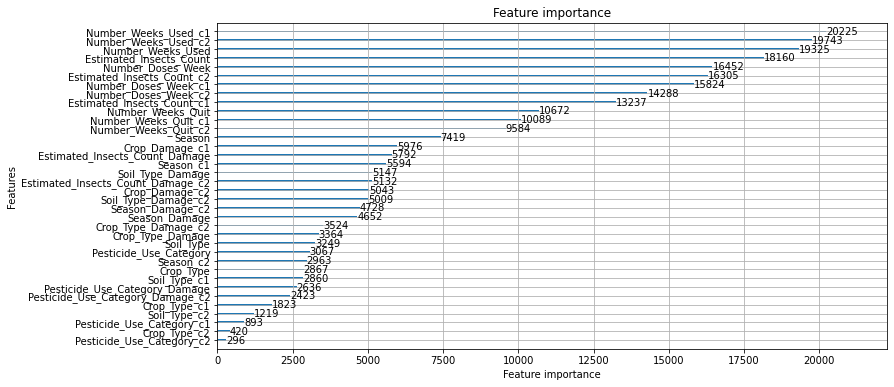

In [7]:
# Actual prediction
clf.fit(dataset_X, dataset_y, eval_metric='multi_error', categorical_feature=cat_cols)
prediction = clf.predict(test_dt)

print(Counter(prediction))

submission = pd.read_csv('sample_data/sample_submission.csv')
submission['Crop_Damage'] = prediction
submission.to_csv('sample_data/submit_prediction.csv')

plt.rcParams['figure.figsize'] = (12, 6)
lgb.plot_importance(clf)
plt.show()